In [ ]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot  as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
# 必要なモジュールがあれば適宜追加してください

# １．データの導入と統計分析

In [ ]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2022A/master/project/winequality-white.csv

--2023-01-13 08:45:58--  https://raw.githubusercontent.com/UTDataMining/2022A/master/project/winequality-white.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [text/plain]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[===================>] 258.23K  --.-KB/s    in 0.04s   

2023-01-13 08:45:58 (6.78 MB/s) - ‘winequality-white.csv’ saved [264426/264426]



In [ ]:
# 白ワインデータセットの読み込み
wine = pd.read_csv("winequality-white.csv", sep=";")

In [ ]:
#欠損データ検査
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

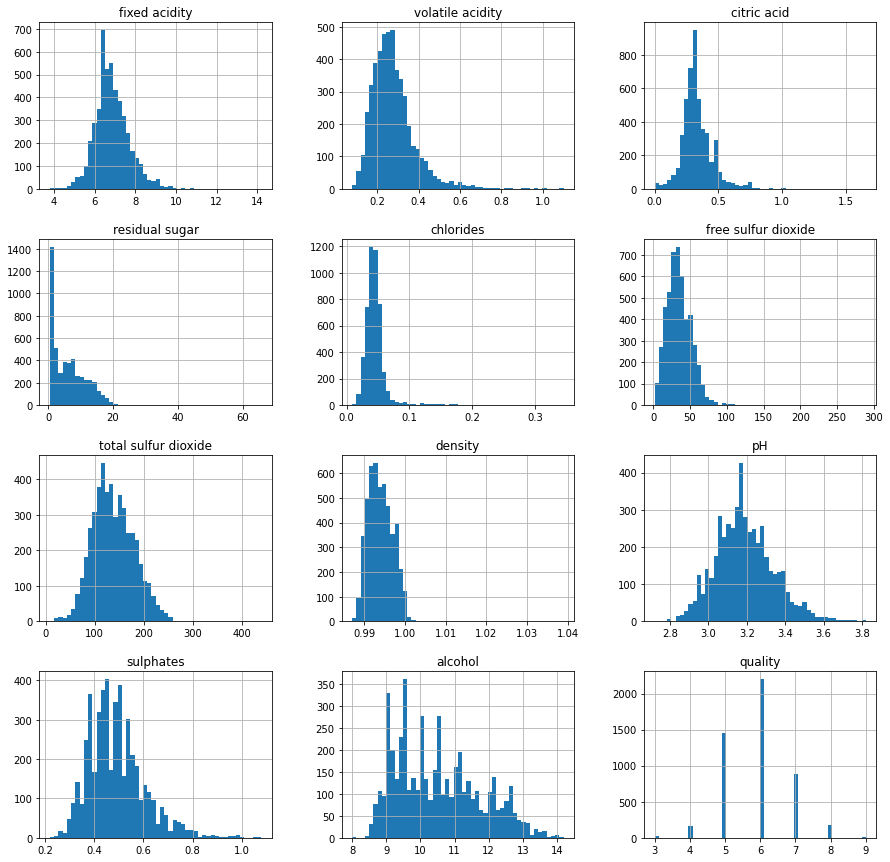

In [ ]:
# 特徴量の分布
wine.hist(bins=50, figsize=(15,15));

In [ ]:
# 特徴量間の相関
wine.corr(method='pearson')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


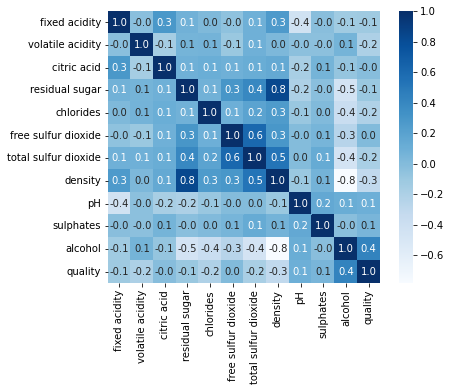

In [ ]:
#相関性の可視化
plt.figure(figsize=(7,5))
sns.heatmap(wine.corr(method='pearson'),square=True, fmt='.1f', annot=True, cmap='Blues');

qualityはalcoholと緩やかな相関性をもつことが分かる。

In [ ]:
# 正解ラベルを1（高品質：ワインのqualityが6以上）か0（低品質：ワインのqualityが6未満）とする
y=wine['quality'].values
y = (y>=6).astype(int)
print(np.sum(y==1, axis=0)) # 高品質ワインデータの数
print(np.sum(y==0, axis=0)) # 低品質ワインデータの数

3258
1640


２．データ分割と学習

logisticregression を用いる場合

In [ ]:
# 訓練データとテストデータに分割

#Xを単一特徴量を使うか或いは全ての特徴量を使うかの場合に次の要らないコードの前に「＃」を付ける
X=wine[ ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
#X=wine[['alcohol']].values

y=wine[['quality']].values
y = (y>=6).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
#logisticregressionを用いる学習
lr=LogisticRegression(solver='liblinear',  multi_class='auto')
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)


print(confusion_matrix(y_test, y_pred)) # 混同行列
print(accuracy_score(y_test, y_pred)) # accuracy
print(precision_score(y_test, y_pred)) # precision
print(recall_score(y_test, y_pred)) # recall
print(f1_score(y_test, y_pred))  # f値
mse=mean_squared_error(y_test,lr.predict(X_test))
print('テストデータ誤差 '+'{:.3f}'.format(mse))

[[164 164]
 [ 74 578]]
0.7571428571428571
0.7789757412398922
0.8865030674846626
0.8292682926829269
テストデータ誤差 0.243


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearRegressionを用いる場合

In [ ]:
# 訓練データとテストデータに分割
#Xを単一特徴量を使うか或いは全ての特徴量を使うかの場合に次の要らないコードの前に「＃」を付ける
X=wine[ ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
#X=wine[['alcohol']].values

y=wine[['quality']].values
y = (y>=6).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
# 標準化

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
#LinearRegressionを用いる学習
lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
y_pred=(y_pred>=0.6).astype(int)

print(confusion_matrix(y_test, y_pred)) # 混同行列
print(accuracy_score(y_test, y_pred)) # accuracy
print(precision_score(y_test, y_pred)) # precision
print(recall_score(y_test, y_pred)) # recall
print(f1_score(y_test, y_pred))  # f値
mse=mean_squared_error(y_test,lr.predict(X_test))
print('テストデータ誤差 '+'{:.3f}'.format(mse))


[[222 106]
 [159 493]]
0.7295918367346939
0.8230383973288815
0.7561349693251533
0.7881694644284573
テストデータ誤差 0.169
